,Open_0,High_0,Low_0,Close_0,Open_1,High_1,Low_1,Close_1,Open_2,High_2,...,Target_Change_in_Lev_Money_Long_All,Target_Change_in_Lev_Money_Short_All,Target_Change_in_Lev_Money_Spread_All,Target_Change_in_Other_Rept_Long_All,Target_Change_in_Other_Rept_Short_All,Target_Change_in_Other_Rept_Spread_All,Target_Change_in_Tot_Rept_Long_All,Target_Change_in_Tot_Rept_Short_All,Target_Change_in_NonRept_Long_All,Target_Change_in_NonRept_Short_All
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-20,1.28159,1.28208,1.28029,1.28078,1.29005,1.29096,1.28884,1.28894,1.28633,1.29091,...,3820.0,-3065.0,-198.0,422.0,931.0,-1.0,1044.0,1927.0,1031.0,148.0
2010-07-27,1.29976,1.30009,1.29874,1.29954,1.30600,1.30876,1.30585,1.30763,1.30674,1.30699,...,30.0,-8733.0,527.0,2076.0,1300.0,1.0,1101.0,5291.0,2807.0,-1383.0
2010-08-03,1.31565,1.31663,1.31510,1.31552,1.31557,1.31647,1.31415,1.31581,1.32797,1.32841,...,-746.0,-10021.0,-323.0,-986.0,1965.0,-25.0,-230.0,2312.0,-1595.0,-4137.0
2010-08-10,1.28969,1.29127,1.28737,1.28840,1.28639,1.28646,1.28389,1.28463,1.27676,1.27911,...,1737.0,14587.0,-30.0,1777.0,-2359.0,0.0,10040.0,12713.0,5774.0,3101.0
2010-08-17,1.28705,1.28771,1.28605,1.28722,1.28339,1.28370,1.27886,1.28209,1.26839,1.27090,...,-6024.0,1940.0,344.0,169.0,-450.0,0.0,-1213.0,-5624.0,-3429.0,982.0


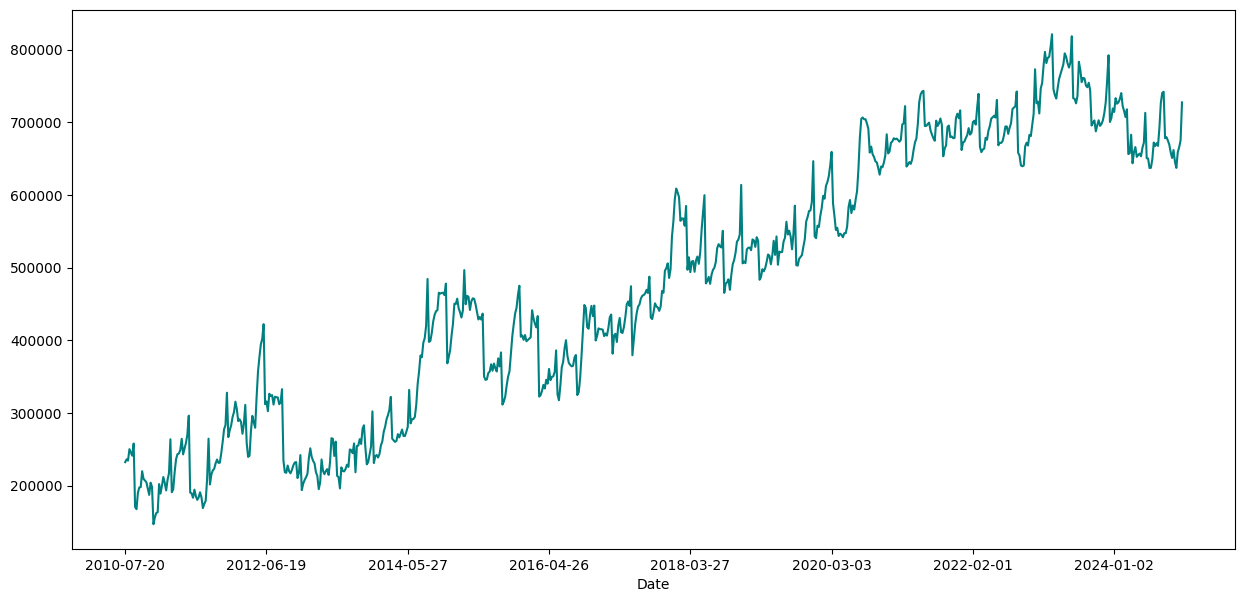

In [10]:
import pandas as pd
import numpy as np
import time
import numpy as np
import pandas as pd
#import pandas_datareader as pdr

from keras.layers import LSTM
from keras.models import Sequential
#from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler



import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Temp2.csv", index_col=0)
#df = df.drop(["Date"], axis=1)
df = df[:-1]
df = df.set_index('Date')
X = df
for col in X.columns:
    if "Target" in col or "Spread" in col or "Change" in col or "Open" in col:
        if "Open_Interest_All" != col:
            X = X.drop([col], axis=1)

# df = df.reindex(index=pd.date_range(df.index.min(), 
#                                           df.index.max(), 
#                                           freq='D')).fillna(method='ffill')

y = df.Target_Open_Interest_All

sp_close_series = y
#plt.style.use('seaborn-poster')
sp_close_series.plot(figsize=(15, 7), color = 'teal')
df.head()

In [11]:
sp_close_series

Date
2010-07-20    232193.0
2010-07-27    236101.0
2010-08-03    234276.0
2010-08-10    250090.0
2010-08-17    245448.0
                ...   
2024-11-05    637105.0
2024-11-12    658774.0
2024-11-19    665553.0
2024-11-26    675059.0
2024-12-03    727276.0
Name: Target_Open_Interest_All, Length: 749, dtype: float64

In [12]:
WINDOW = 7
PRED_LENGTH = int(WINDOW/2)
def get_reg_train_test(timeseries,sequence_length= 51,
                   train_size=0.9,roll_mean_window=5,
                   normalize=True,scale=False):
    # smoothen out series
    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()
    
    # create windows
    result = []
    for index in range(len(timeseries) - sequence_length):
        result.append(timeseries[index: index + sequence_length])
           
    # normalize data as a variation of 0th index
    if normalize:
        normalised_data = []
        for window in result:
            normalised_window = [((float(p) / float(window[0])) - 1) \
                                   for p in window]
            normalised_data.append(normalised_window)
        
        result = normalised_data
    # identify train-test splits
    result = np.array(result) 
    row = round(train_size * result.shape[0])
    
    # split train and test sets
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    # scale data in 0-1 range
    scaler = None
    if scale:
        scaler=MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
      
    # split independent and dependent variables  
    x_train = train[:, :-1]
    y_train = train[:, -1]
        
        
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    # Transforms for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], 
                                   x_train.shape[1], 
                                   1))
    x_test = np.reshape(x_test, (x_test.shape[0], 
                                 x_test.shape[1], 
                                 1)) 
    
    return x_train,y_train,x_test,y_test,scaler






x_train,y_train,x_test,y_test,scaler = get_reg_train_test(sp_close_series,
                                                      sequence_length=WINDOW+1,
                                                      roll_mean_window=None,
                                                      normalize=False,
                                                      scale=True)
    
print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(667, 7, 1)
y_train shape=(667,)
x_test shape=(74, 7, 1)
y_test shape=(74,)


In [13]:
from keras.layers import LSTM
from keras.models import Sequential
#from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
import time

def get_reg_model(layer_units=[100,100],dropouts=[0.2,0.2],window_size=50):
    # build LSTM network
    model = Sequential()
    
    # hidden layer 1
    model.add(LSTM(layer_units[0], 
                   input_shape=(window_size,1), 
                   return_sequences=True))
    model.add(Dropout(dropouts[0]))
    
    # hidden layer 2
    model.add(LSTM(layer_units[1]))
    model.add(Dropout(dropouts[1]))
    
    # output layer
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mae", optimizer="Adam")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model

lstm_model=None
try:
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)   
except:
    print("Model Build Failed. Trying Again")
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)

2025-01-02 12:12:24.271140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-02 12:12:24.643466: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/dhauryk/anaconda3/envs/temp_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


> Compilation Time :  0.04252028465270996


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,901 (276.96 KB)

 Trainable params: 70,901 (276.96 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error



callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=3,
                                           verbose=0,
                                           restore_best_weights=True)]
lstm_model.fit(x_train, y_train, 
               epochs=100, #batch_size=16,
               verbose=1,validation_split=0.30,
               callbacks=callbacks)
print("Model Fit Complete")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - loss: 0.2056 - val_loss: 0.1231
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0655 - val_loss: 0.0435
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0478 - val_loss: 0.0457
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.0499 - val_loss: 0.0474
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0503 - val_loss: 0.0433
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0456 - val_loss: 0.0688
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0510 - val_loss: 0.0542
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0455 - val_loss: 0.0471
Model Fit Complete


In [15]:
import math
def predict_reg_multiple(model, data, window_size=6, prediction_len=3):
    prediction_list = []
    
    # loop for every sequence in the dataset
    for window in range(int(len(data)/prediction_len)):
        _seq = data[window*prediction_len]
        predicted = []
        # loop till required prediction length is achieved
        for j in range(prediction_len):
            predicted.append(model.predict(_seq[np.newaxis,:,:])[0,0])
            _seq = _seq[1:]
            _seq = np.insert(_seq, [window_size-1], predicted[-1], axis=0)
        prediction_list.append(predicted)
    return prediction_list


train_pred_seqs = predict_reg_multiple(lstm_model,
                                             x_train,
                                             window_size=WINDOW,
                                             prediction_len=PRED_LENGTH)

train_offset = y_train.shape[0] - np.array(train_pred_seqs).flatten().shape[0]

train_rmse = math.sqrt(mean_absolute_error(y_train[train_offset:], 
                                          np.array(train_pred_seqs).\
                                          flatten()))
print('Train Score: %.2f MAE' % (train_rmse))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
test_pred_seqs = predict_reg_multiple(lstm_model,
                                      x_test,
                                      window_size=WINDOW,
                                      prediction_len=PRED_LENGTH)
test_offset = y_test.shape[0] - np.array(test_pred_seqs).flatten().shape[0]

test_rmse = math.sqrt(mean_absolute_error(y_test[test_offset:], 
                                          np.array(test_pred_seqs).\
                                          flatten()))
print('Test Score: %.2f MAE' % (test_rmse))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

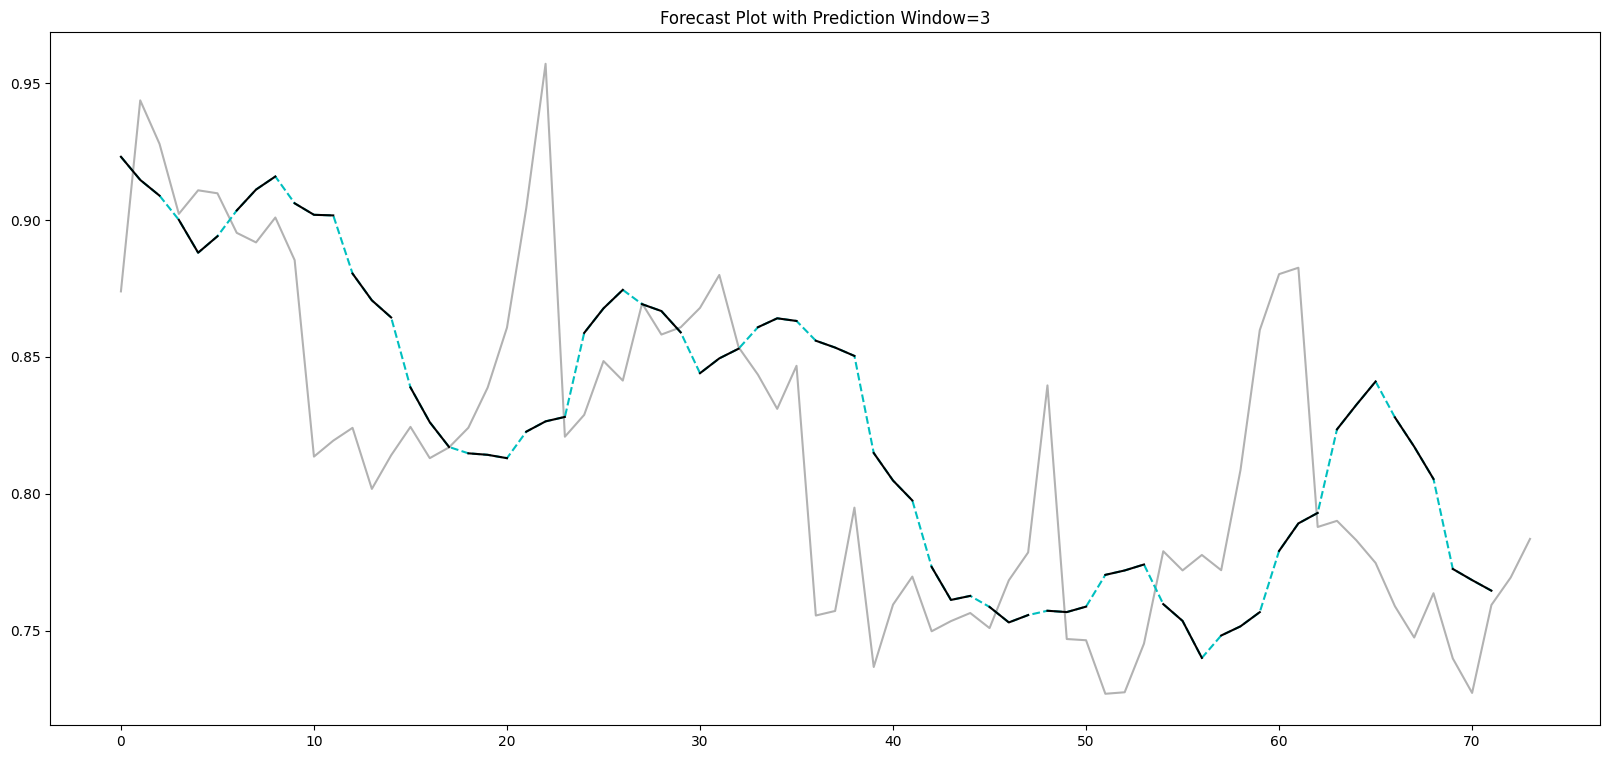

In [17]:
def plot_reg_results(predicted_data, true_data, prediction_len=3):
    fig = plt.figure(facecolor='white', figsize=(20, 9))
    ax = fig.add_subplot(111)
    
    # plot actual data
    ax.plot(true_data, 
            label='True Data',
            c='black',alpha=0.3)
    
    # plot flattened data
    plt.plot(np.array(predicted_data).flatten(), 
             label='Prediction_full',
             c='c',linestyle='--')
    
    #plot each window in the prediction list
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction',c='black')

    plt.title("Forecast Plot with Prediction Window={}".format(prediction_len))
    plt.show()



plot_reg_results(test_pred_seqs,y_test,prediction_len=PRED_LENGTH)